In [1]:
import numpy as np
import pandas as pd 
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
from geopy.distance import vincenty
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

C:\Users\Aditya\Anaconda2\envs\tensorflow_win\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
weather_data = pd.read_csv("weather_data.csv")

In [3]:
if train.count().min() == train.shape[0] and test.count().min() == test.shape[0]:
    print('No missing values.') 

No missing values.


In [4]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"]) #Splitting up datetime features
train["dropoff_datetime"] = pd.to_datetime(train["dropoff_datetime"])

test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])
weather_data['date'] = pd.to_datetime(weather_data['date'])

train['pickup_date'] = train.loc[:,'pickup_datetime'].dt.date
train['pickup_month'] = train.loc[:,'pickup_datetime'].dt.month
train['pickup_dayofweek'] = train.loc[:,'pickup_datetime'].dt.dayofweek
train['pickup_hour'] = train.loc[:,'pickup_datetime'].dt.hour
train['pickup_day'] = train.loc[:,'pickup_datetime'].dt.day
train['pickup_second'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()

test['pickup_date'] = test.loc[:,'pickup_datetime'].dt.date
test['pickup_month']=test.loc[:,'pickup_datetime'].dt.month
test['pickup_dayofweek']=test.loc[:,'pickup_datetime'].dt.dayofweek
test['pickup_hour']=test.loc[:,'pickup_datetime'].dt.hour
test['pickup_day'] = test.loc[:,'pickup_datetime'].dt.day
test['pickup_second'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()

weather_data['date'] = weather_data.loc[:,'date'].dt.date

In [5]:
weather_data.tail()

,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
361,2016-12-27,60,40,50.000,0,0,0
362,2016-12-28,40,34,37.000,0,0,0
363,2016-12-29,46,33,39.500,0.39,0,0
364,2016-12-30,40,33,36.500,0.01,T,0
365,2016-12-31,44,31,37.500,0,0,0


In [6]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
date                   366 non-null object
maximum temerature     366 non-null int64
minimum temperature    366 non-null int64
average temperature    366 non-null float64
precipitation          366 non-null object
snow fall              366 non-null object
snow depth             366 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 20.1+ KB


In [7]:
weather_data = weather_data.replace(to_replace='T', value=0.01)  #Cleaning weather data

weather_data['precipitation'] = pd.to_numeric(weather_data['precipitation'])
weather_data['snow fall'] = pd.to_numeric(weather_data['snow fall'])
weather_data['snow depth'] = pd.to_numeric(weather_data['snow depth'])

In [8]:
train = train.merge(weather_data, left_on='pickup_date', right_on='date', how='inner') #Merging Datasets
test = test.merge(weather_data, left_on='pickup_date', right_on='date', how='inner')

In [9]:
train = train.drop(['pickup_date', 'pickup_datetime', 'dropoff_datetime', 'date'], axis = 1)
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_dayofweek,pickup_hour,pickup_day,pickup_second,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,1,-73.982,40.768,-73.965,40.766,N,455,3,0,17,14,6369878.000,51,40,45.500,0.290,0.000,0.000
1,id2129090,1,1,-73.975,40.759,-73.953,40.765,N,1346,3,0,14,14,6357922.000,51,40,45.500,0.290,0.000,0.000
2,id0256505,1,1,-73.994,40.745,-73.999,40.723,N,695,3,0,15,14,6361461.000,51,40,45.500,0.290,0.000,0.000
3,id3863815,2,3,-73.944,40.714,-73.911,40.709,N,755,3,0,4,14,6323059.000,51,40,45.500,0.290,0.000,0.000
4,id3817493,2,1,-73.953,40.766,-73.979,40.762,N,1050,3,0,14,14,6361059.000,51,40,45.500,0.290,0.000,0.000


In [10]:
m = np.mean(train['trip_duration'])         #Removing outlier trip durations
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 4*s]
train = train[train['trip_duration'] >= m - 4*s]

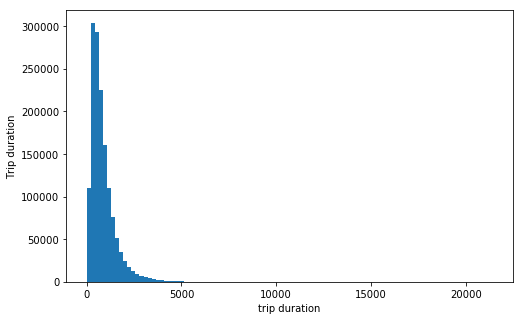

In [11]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.hist(train['trip_duration'],bins=100)

plt.xlabel('trip duration')
plt.ylabel('Trip duration')
plt.show()

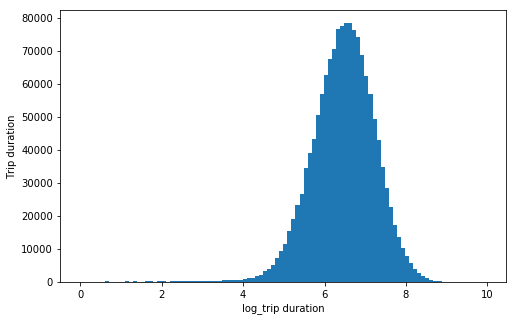

Max trip duration is 5.9475 Hours


In [12]:
train['log_trip_duration'] = np.log(train['trip_duration']) #Applying log transformation to trip duration
plt.hist(np.log(train['trip_duration']),bins=100,  alpha=1)
plt.xlabel('log_trip duration')
plt.ylabel('Trip duration')
plt.show()
print("Max trip duration is",train['trip_duration'].max()/3600, "Hours")

In [13]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

In [14]:
train = train[train['pickup_longitude'] <= max(city_long_border)]   # Removing outlier coordinates
train = train[train['pickup_longitude'] >= min(city_long_border)]
train = train[train['pickup_latitude'] <= max(city_lat_border)]
train = train[train['pickup_latitude'] >= min(city_lat_border)]
train = train[train['dropoff_longitude'] <= max(city_long_border)]
train = train[train['dropoff_longitude'] >= min(city_long_border)]
train = train[train['dropoff_latitude'] <= max(city_lat_border)]
train = train[train['dropoff_latitude'] >= min(city_lat_border)]

In [15]:
pickup_coords = np.stack((train['pickup_latitude'], train['pickup_longitude']), axis=1)  #Calculating distance feature
dropoff_coords = np.stack((train['dropoff_latitude'], train['dropoff_longitude']), axis=1)
train['distance'] = [vincenty(x, y).km for x,y in tqdm(zip(pickup_coords,dropoff_coords))]

1437168it [00:47, 30430.51it/s]


In [16]:
pickup_coords = np.stack((test['pickup_latitude'], test['pickup_longitude']), axis=1)
dropoff_coords = np.stack((test['dropoff_latitude'], test['dropoff_longitude']), axis=1)
test['distance'] = [vincenty(x, y).km for x,y in tqdm(zip(pickup_coords,dropoff_coords))]

625134it [00:20, 29939.78it/s]


In [17]:
v_data = train.drop(['id','trip_duration','store_and_fwd_flag'],axis=1)

vendor_id


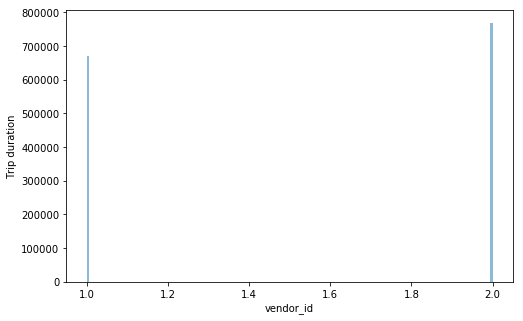

passenger_count


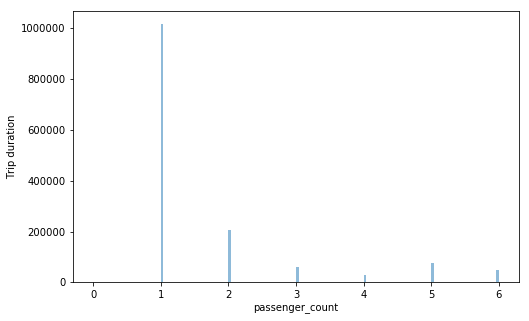

pickup_longitude


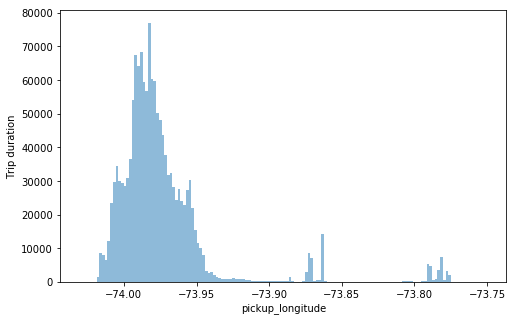

pickup_latitude


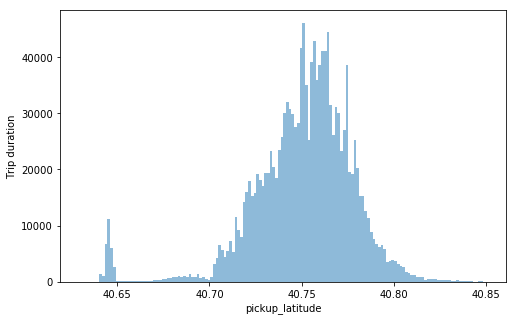

dropoff_longitude


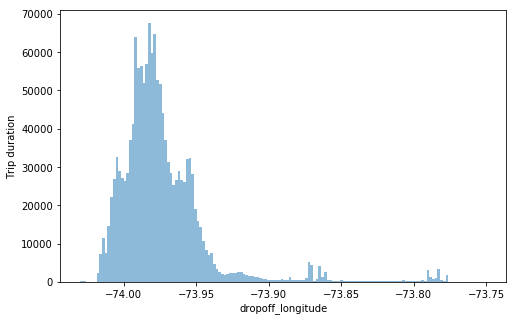

dropoff_latitude


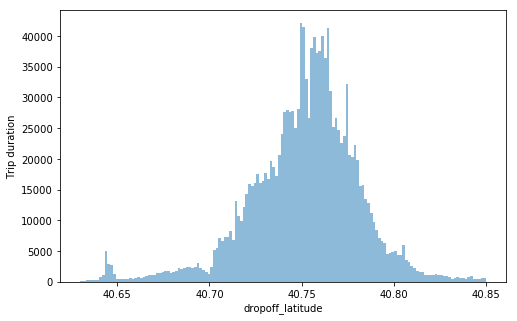

pickup_month


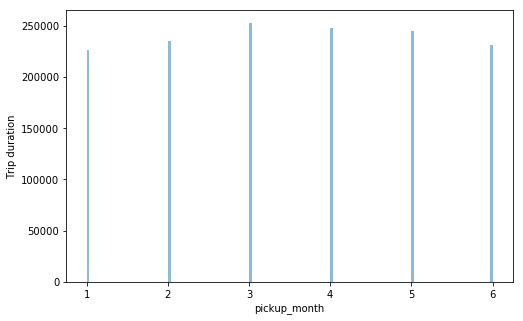

pickup_dayofweek


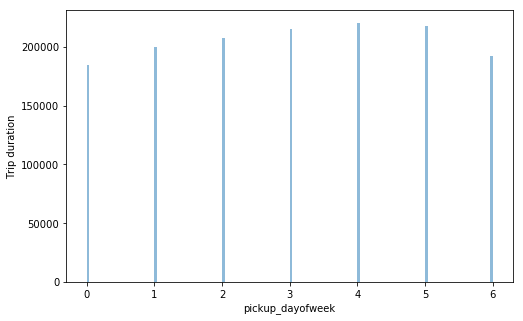

pickup_hour


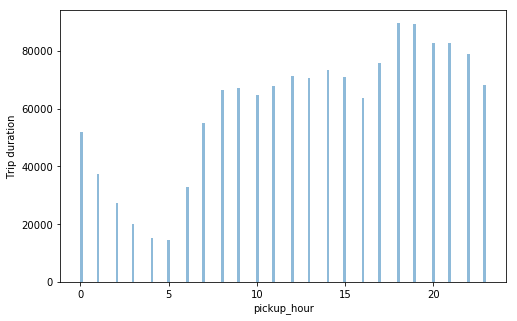

pickup_day


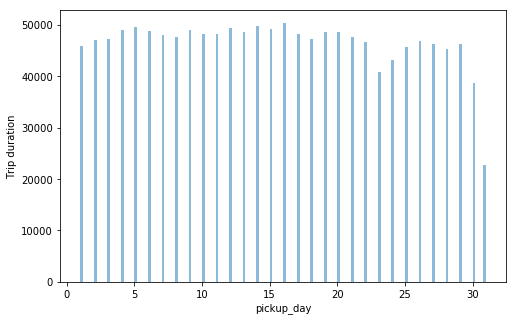

pickup_second


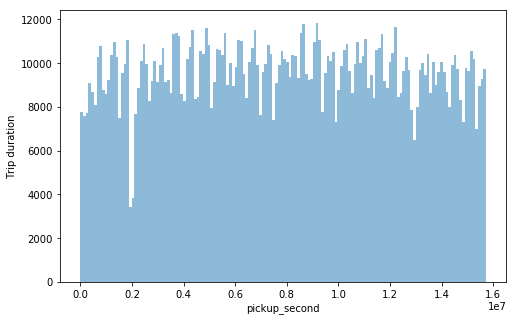

maximum temerature


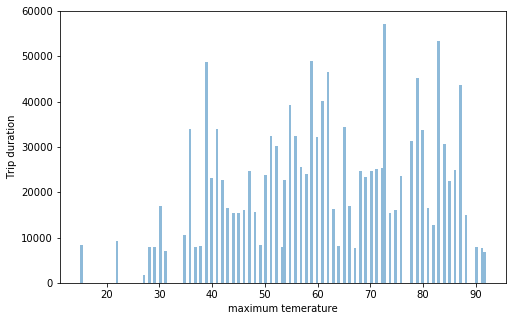

minimum temperature


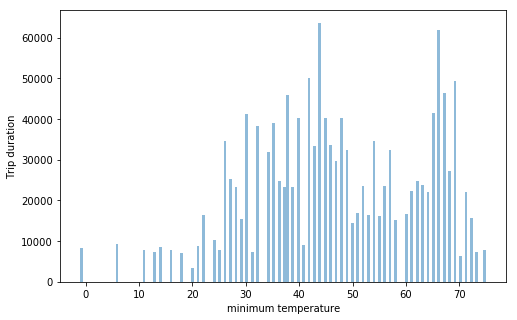

average temperature


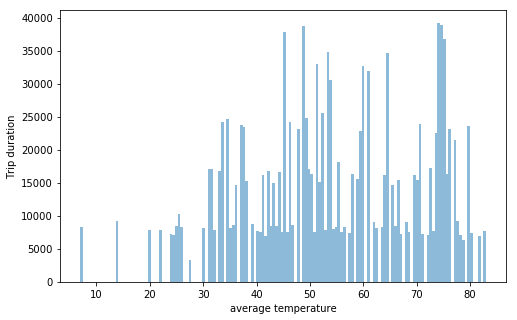

precipitation


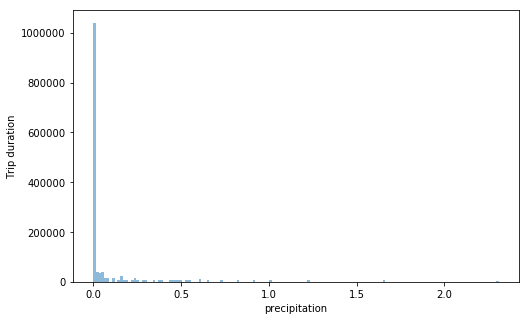

snow fall


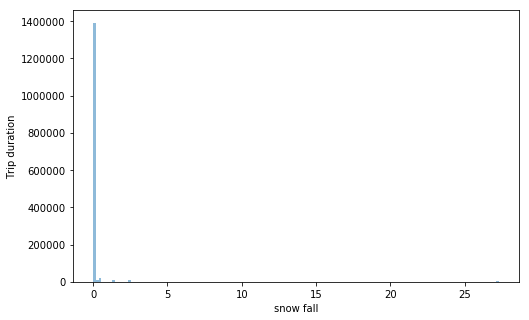

snow depth


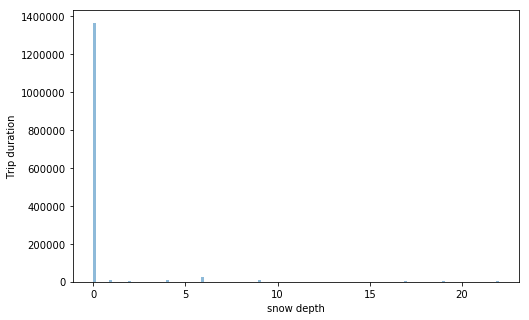

log_trip_duration


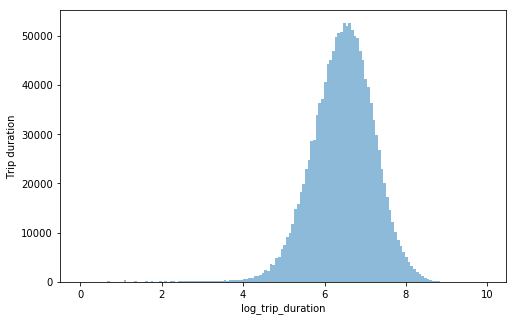

distance


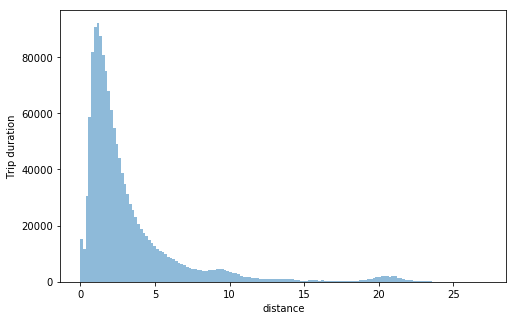

In [18]:
for f in list(v_data.columns.values):   # Visualising feature distributions
    print(f)
    plt.hist(v_data[f],bins=150,  alpha=0.5)
    plt.xlabel(f)
    plt.ylabel('Trip duration')
    plt.show()

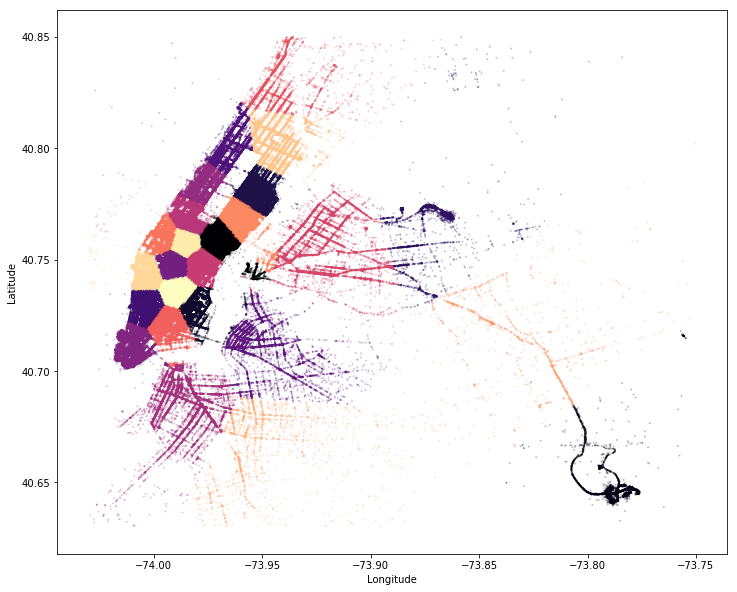

In [19]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,   #Running Kmeans clustering 
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))
kmeans = MiniBatchKMeans(n_clusters=25, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])


plt.rcParams['figure.figsize'] = [12, 10]
plt.scatter(train.pickup_longitude.values, train.pickup_latitude.values, s=1, c=train.pickup_cluster.values, cmap='magma', alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

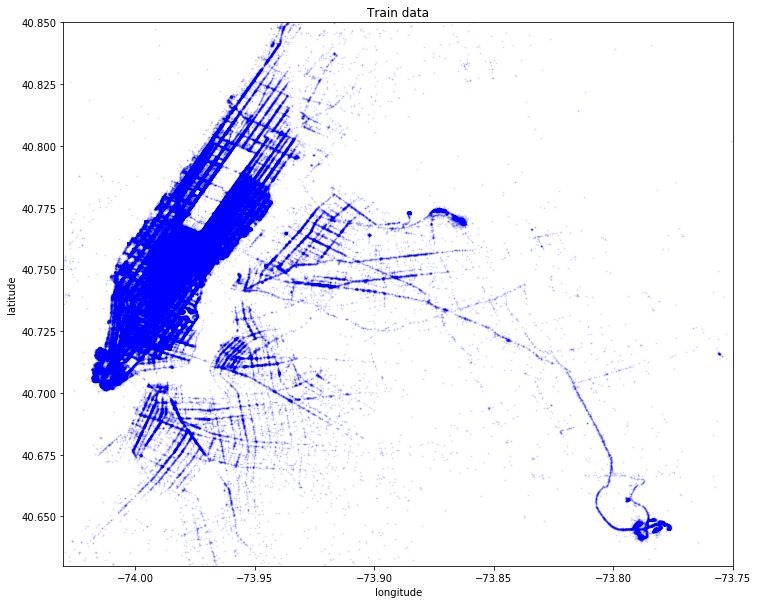

In [20]:
plt.scatter(train['pickup_longitude'].values, train['pickup_latitude'].values, color='blue', s=1, alpha=0.1)
plt.title("Train data")
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

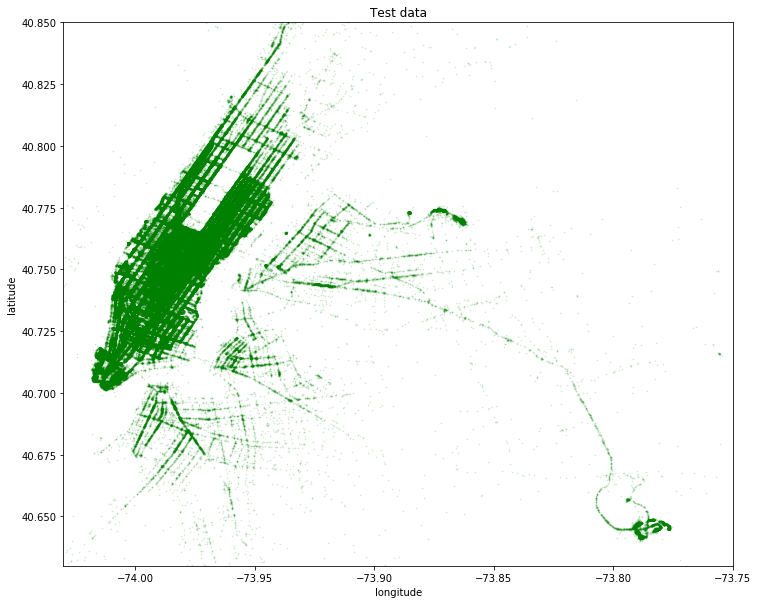

In [21]:
plt.scatter(test['pickup_longitude'].values, test['pickup_latitude'].values, color='green',s =1, alpha=0.1)
plt.title("Test data")
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.savefig('test.png')
plt.show()

In [22]:
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_dayofweek,pickup_hour,pickup_day,pickup_second,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth,log_trip_duration,distance,pickup_cluster,dropoff_cluster
0,id2875421,2,1,-73.982,40.768,-73.965,40.766,N,455,3,0,17,14,6369878.000,51,40,45.500,0.290,0.000,0.000,6.120,1.502,12,18
1,id2129090,1,1,-73.975,40.759,-73.953,40.765,N,1346,3,0,14,14,6357922.000,51,40,45.500,0.290,0.000,0.000,7.205,1.976,0,18
2,id0256505,1,1,-73.994,40.745,-73.999,40.723,N,695,3,0,15,14,6361461.000,51,40,45.500,0.290,0.000,0.000,6.544,2.514,8,16
3,id3863815,2,3,-73.944,40.714,-73.911,40.709,N,755,3,0,4,14,6323059.000,51,40,45.500,0.290,0.000,0.000,6.627,2.912,7,7
4,id3817493,2,1,-73.953,40.766,-73.979,40.762,N,1050,3,0,14,14,6361059.000,51,40,45.500,0.290,0.000,0.000,6.957,2.232,18,12


In [23]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #Displaying important statistics
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_dayofweek,pickup_hour,pickup_day,pickup_second,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth,log_trip_duration,distance,pickup_cluster,dropoff_cluster
count,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000,1437168.000
mean,1.534,1.664,-73.974,40.751,-73.974,40.752,824.815,3.516,3.048,13.616,15.502,7896344.665,61.758,46.728,54.243,0.089,0.059,0.407,6.447,3.295,11.378,11.544
std,0.499,1.314,0.037,0.027,0.033,0.030,649.064,1.681,1.954,6.379,8.702,4455288.371,16.980,15.719,16.148,0.233,0.939,2.246,0.771,3.668,7.673,7.471
min,1.000,0.000,-74.030,40.630,-74.030,40.630,1.000,1.000,0.000,0.000,1.000,0.000,15.000,-1.000,7.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,394.000,2.000,1.000,9.000,8.000,4117631.750,49.000,36.000,42.500,0.000,0.000,0.000,5.976,1.225,5.000,5.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,655.000,4.000,3.000,14.000,15.000,7920125.000,61.000,46.000,53.500,0.000,0.000,0.000,6.485,2.068,11.000,12.000
75%,2.000,2.000,-73.968,40.768,-73.963,40.770,1056.000,5.000,5.000,19.000,23.000,11674783.500,76.000,61.000,69.500,0.040,0.000,0.000,6.962,3.767,18.000,18.000
max,2.000,6.000,-73.751,40.850,-73.750,40.850,21411.000,6.000,6.000,23.000,31.000,15724762.000,92.000,75.000,83.000,2.310,27.300,22.000,9.972,27.197,24.000,24.000


In [24]:
train.corr()  #Correlation between features and target variable

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_dayofweek,pickup_hour,pickup_day,pickup_second,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth,log_trip_duration,distance,pickup_cluster,dropoff_cluster
vendor_id,1.000,0.288,0.017,0.004,0.005,0.006,0.009,-0.006,0.001,0.009,0.001,-0.006,-0.005,-0.005,-0.005,0.001,0.000,0.006,0.012,0.010,-0.006,-0.003
passenger_count,0.288,1.000,0.005,-0.005,0.000,-0.002,0.015,-0.002,0.025,0.009,0.002,-0.002,-0.002,-0.002,-0.002,0.001,0.000,0.001,0.019,0.012,-0.000,0.001
pickup_longitude,0.017,0.005,1.000,-0.135,0.257,0.048,0.362,0.007,-0.030,0.019,0.000,0.007,0.004,0.004,0.004,-0.000,-0.004,0.009,0.207,0.532,-0.323,-0.043
pickup_latitude,0.004,-0.005,-0.135,1.000,0.064,0.441,-0.234,-0.004,-0.036,0.013,-0.007,-0.005,-0.002,-0.001,-0.001,-0.001,-0.006,-0.000,-0.171,-0.326,-0.004,-0.054
dropoff_longitude,0.005,0.000,0.257,0.064,1.000,0.073,0.254,0.009,-0.002,-0.051,0.001,0.009,0.006,0.006,0.006,0.001,0.002,0.005,0.160,0.416,-0.089,-0.209
dropoff_latitude,0.006,-0.002,0.048,0.441,0.073,1.000,-0.196,-0.002,-0.028,0.017,-0.007,-0.003,-0.001,-0.001,-0.001,0.000,-0.002,0.000,-0.156,-0.203,-0.047,-0.027
trip_duration,0.009,0.015,0.362,-0.234,0.254,-0.196,1.000,0.059,-0.035,0.030,0.012,0.060,0.026,0.024,0.025,-0.012,-0.004,0.021,0.854,0.765,-0.108,-0.037
pickup_month,-0.006,-0.002,0.007,-0.004,0.009,-0.002,0.059,1.000,-0.015,-0.003,-0.015,0.986,0.502,0.463,0.489,-0.016,-0.050,-0.266,0.048,0.017,-0.004,-0.003
pickup_dayofweek,0.001,0.025,-0.030,-0.036,-0.002,-0.028,-0.035,-0.015,1.000,-0.083,0.004,-0.014,-0.052,-0.043,-0.048,-0.088,0.003,-0.028,-0.031,0.008,0.023,0.014
pickup_hour,0.009,0.009,0.019,0.013,-0.051,0.017,0.030,-0.003,-0.083,1.000,0.001,0.002,0.002,-0.000,0.001,-0.014,-0.050,0.014,0.041,-0.016,-0.027,0.005


In [25]:
month_c = pd.get_dummies(train['pickup_month'], prefix='month', prefix_sep='_') #One hot encoding
dayofweek_c = pd.get_dummies(train['pickup_dayofweek'], prefix='dayofweek', prefix_sep='_')
hour_c = pd.get_dummies(train['pickup_hour'], prefix='hour', prefix_sep='_')
fwd_flag_c = pd.get_dummies(train['store_and_fwd_flag'], prefix='fwd', prefix_sep="_")
passenger_count_c = pd.get_dummies(train['passenger_count'], prefix='passengers', prefix_sep="_")
vendor_id_c = pd.get_dummies(train['vendor_id'], prefix='vendor', prefix_sep="_")

train = pd.concat([train, fwd_flag_c ], axis=1)
train_c = pd.concat([train, month_c, dayofweek_c, hour_c, fwd_flag_c, passenger_count_c, vendor_id_c], axis=1)
train_c = train_c.drop(['pickup_month','pickup_dayofweek', 'pickup_hour', 'store_and_fwd_flag', 'passenger_count','vendor_id'],axis=1)

In [26]:
month_c = pd.get_dummies(test['pickup_month'], prefix='month', prefix_sep='_')
dayofweek_c = pd.get_dummies(test['pickup_dayofweek'], prefix='dayofweek', prefix_sep='_')
hour_c = pd.get_dummies(test['pickup_hour'], prefix='hour', prefix_sep='_')
fwd_flag_c = pd.get_dummies(test['store_and_fwd_flag'], prefix='fwd', prefix_sep="_")
passenger_count_c = pd.get_dummies(test['passenger_count'], prefix='passengers', prefix_sep="_")
vendor_id_c = pd.get_dummies(test['vendor_id'], prefix='vendor', prefix_sep="_")

test = pd.concat([test, fwd_flag_c], axis=1)
test_c = pd.concat([test, month_c, dayofweek_c, hour_c, fwd_flag_c, passenger_count_c, vendor_id_c], axis=1)
test_c = test_c.drop(['passengers_9','pickup_month','pickup_dayofweek', 'pickup_hour', 'store_and_fwd_flag', 'passenger_count','vendor_id'],axis=1)

In [28]:
train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_dayofweek,pickup_hour,pickup_day,pickup_second,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth,log_trip_duration,distance,pickup_cluster,dropoff_cluster,fwd_N,fwd_Y
0,id2875421,2,1,-73.982,40.768,-73.965,40.766,N,455,3,0,17,14,6369878.000,51,40,45.500,0.290,0.000,0.000,6.120,1.502,12,18,1,0
1,id2129090,1,1,-73.975,40.759,-73.953,40.765,N,1346,3,0,14,14,6357922.000,51,40,45.500,0.290,0.000,0.000,7.205,1.976,0,18,1,0
2,id0256505,1,1,-73.994,40.745,-73.999,40.723,N,695,3,0,15,14,6361461.000,51,40,45.500,0.290,0.000,0.000,6.544,2.514,8,16,1,0
3,id3863815,2,3,-73.944,40.714,-73.911,40.709,N,755,3,0,4,14,6323059.000,51,40,45.500,0.290,0.000,0.000,6.627,2.912,7,7,1,0
4,id3817493,2,1,-73.953,40.766,-73.979,40.762,N,1050,3,0,14,14,6361059.000,51,40,45.500,0.290,0.000,0.000,6.957,2.232,18,12,1,0


In [29]:
new_test_cat = test_c.drop(['pickup_datetime', 'pickup_date', 'date'],axis=1)
new_train_cat = train_c.drop(['id'],axis=1)
new_test = test.drop(['pickup_datetime', 'pickup_date', 'date', 'store_and_fwd_flag'],axis=1)
new_train = train.drop(['id', 'store_and_fwd_flag'],axis=1)

In [30]:
new_train.to_csv('new_train.csv', index=False)   #Saing new training data as csv files
new_test.to_csv('new_test.csv', index=False)
new_train_cat.to_csv('new_train_cat.csv', index=False)
new_test_cat.to_csv('new_test_cat.csv', index=False)